# Week 4

Physical environmental variables regressed on seaice.   We start by loading in the different variables and inspecting the data.

In [1]:
import xarray as xr
import pandas as pd
import itertools
from tqdm import tqdm
from modules import *
import matplotlib.pyplot as plt
import numpy as np
pd.set_option('display.float_format', '{:.3f}'.format)

In [2]:
# ds = xr.open_mfdataset('processed_data/ERA5-levels/*', chunks={'time':167})

In [3]:
# for variable in ds:
#     if 'level' in ds[variable].dims:
#         for level in ds.level:
#             ds[variable+'_'+str(level.values)] = ds[variable].sel(level=level)
#         ds = ds.drop(variable)
# ds = ds.drop('level')

In [4]:
# seaice = w3.load_data(['seaice'],projection='SouthPolarStereo', temporal_resolution='annual',temporal_decomposition='anomalous',detrend='raw')

In [5]:
# ds = ds.interp(time=seaice.time)
# ds.to_netcdf('processed_data/environmental.nc')

In [6]:
ds = xr.open_dataset('processed_data/environmental.nc')
ds

<xarray.Dataset>
Dimensions:  (time: 42, x: 316, y: 332)
Coordinates:
  * y        (y) int32 4350000 4325000 4300000 ... -3875000 -3900000 -3925000
  * x        (x) int32 -3950000 -3925000 -3900000 ... 3875000 3900000 3925000
  * time     (time) datetime64[ns] 1979-01-01 1980-01-01 ... 2020-01-01
Data variables:
    si10     (time, y, x) float64 ...
    skt      (time, y, x) float64 ...
    sp       (time, y, x) float64 ...
    ssr      (time, y, x) float64 ...
    ssrd     (time, y, x) float64 ...
    sst      (time, y, x) float64 ...
    t2m      (time, y, x) float64 ...
    u10      (time, y, x) float64 ...
    v10      (time, y, x) float64 ...
    o3_200   (time, y, x) float64 ...
    o3_500   (time, y, x) float64 ...
    o3_700   (time, y, x) float64 ...
    t_200    (time, y, x) float64 ...
    t_500    (time, y, x) float64 ...
    t_700    (time, y, x) float64 ...
    u_200    (time, y, x) float64 ...
    u_500    (time, y, x) float64 ...
    u_700    (time, y, x) float64 ...
    v_200    (time, y, x) float64 ...
    v_500    (time, y, x) float64 ...
    v_700    (time, y, x) float64 ...
    z_200    (time, y, x) float64 ...
    z_500    (time, y, x) float64 ...
    z_700    (time, y, x) float64 ...

In [25]:
ds = xr.open_dataset('processed_data/environmental.nc')
v = [v for v in ds]
correlation_matrix = pd.DataFrame(index=v,columns=v, dtype=np.float64)
for v1,v2 in tqdm(list(itertools.product(v,v))):
    vec1 = ds[v1].mean(dim=('x','y'))
    vec2 = ds[v2].mean(dim=('x','y'))
#     fig = plt.figure()
#     ax = plt.gca()
#     ax.plot(vec1.time,vec1)
#     ax2 = ax.twinx()
#     ax2.plot([],[])
#     ax2.plot(vec1.time,vec2)
#     plt.title(f'{v1} and {v2}')
#     plt.show()
    correlation_matrix.loc[v1,v2]=xr.corr(vec1,vec2).values

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 576/576 [00:54<00:00, 10.52it/s]


In [26]:
def significant_bold(val, sig_level=0.9):
    bold = 'bold' if val > sig_level else ''
    return 'font-weight: %s' % bold

In [27]:
correlation_matrix.to_latex('H:\\Github/Environmental-Impact-on-Sea-Ice/correlations.tex')
correlation_matrix.style.applymap(significant_bold,sig_level=0.9)

,si10,skt,sp,ssr,ssrd,sst,t2m,u10,v10,o3_200,o3_500,o3_700,t_200,t_500,t_700,u_200,u_500,u_700,v_200,v_500,v_700,z_200,z_500,z_700
si10,1.000000,-0.610192,-0.722016,0.314642,0.415909,-0.547637,-0.505262,0.817590,-0.697487,0.357170,0.357170,0.357170,-0.555901,-0.547158,-0.555897,0.821934,0.821923,0.821945,0.049614,0.049661,0.049572,-0.735375,-0.735381,-0.735373
skt,-0.610192,1.000000,0.571246,-0.400941,-0.574234,0.815824,0.982884,-0.669398,0.581224,0.076503,0.076503,0.076503,0.682250,0.682521,0.682250,-0.728014,-0.728009,-0.728023,0.016570,0.016544,0.016584,0.792509,0.792510,0.792506
sp,-0.722016,0.571246,1.000000,-0.283371,-0.388930,0.364748,0.515523,-0.804376,0.700641,-0.171712,-0.171712,-0.171713,0.324288,0.345751,0.324285,-0.781099,-0.781100,-0.781097,-0.000113,-0.000121,-0.000116,0.888440,0.888438,0.888442
ssr,0.314642,-0.400941,-0.283371,1.000000,0.918426,-0.260655,-0.425500,0.223715,-0.091376,0.018280,0.018280,0.018280,-0.532393,-0.534031,-0.532393,0.255390,0.255390,0.255386,0.081413,0.081415,0.081403,-0.494526,-0.494528,-0.494528
ssrd,0.415909,-0.574234,-0.388930,0.918426,1.000000,-0.458950,-0.587402,0.337046,-0.195593,0.082924,0.082923,0.082924,-0.582717,-0.586497,-0.582719,0.385324,0.385324,0.385321,0.112243,0.112263,0.112222,-0.599729,-0.599730,-0.599732
sst,-0.547637,0.815824,0.364748,-0.260655,-0.458950,1.000000,0.774543,-0.493200,0.408931,-0.042284,-0.042284,-0.042284,0.579149,0.577167,0.579149,-0.537969,-0.537963,-0.537979,0.011881,0.011827,0.011911,0.555911,0.555913,0.555908
t2m,-0.505262,0.982884,0.515523,-0.425500,-0.587402,0.774543,1.000000,-0.582770,0.464410,0.176392,0.176392,0.176392,0.674481,0.679671,0.674482,-0.630289,-0.630287,-0.630297,-0.035918,-0.035934,-0.035914,0.766760,0.766759,0.766758
u10,0.817590,-0.669398,-0.804376,0.223715,0.337046,-0.493200,-0.582770,1.000000,-0.863662,0.181501,0.181501,0.181501,-0.425274,-0.433458,-0.425271,0.969511,0.969514,0.969510,0.080113,0.080149,0.080093,-0.769924,-0.769924,-0.769922
v10,-0.697487,0.581224,0.700641,-0.091376,-0.195593,0.408931,0.464410,-0.863662,1.000000,-0.223869,-0.223869,-0.223870,0.353042,0.360577,0.353039,-0.916538,-0.916533,-0.916541,0.356272,0.356230,0.356294,0.655003,0.655005,0.655000
o3_200,0.357170,0.076503,-0.171712,0.018280,0.082924,-0.042284,0.176392,0.181501,-0.223869,1.000000,1.000000,1.000000,0.057644,0.074488,0.057645,0.189659,0.189654,0.189658,0.035895,0.035933,0.035861,-0.020139,-0.020146,-0.020138


<ipython-input-28-7f96a8e048b9>:1: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  plt.pcolormesh(v,v,correlation_matrix.transpose())


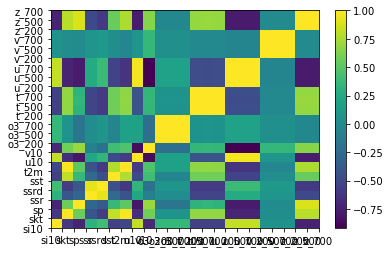

In [28]:
plt.pcolormesh(v,v,correlation_matrix.transpose())
plt.colorbar()
plt.show()